In [4]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from NFconstants import N_nod, beta
from NFandist import get_O
from NFandist import get_diag

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)




False


In [6]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap=swap

    def g(self, z: torch.Tensor) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        z1, z2 = self.split(z,self.swap)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        log_det = -s.sum(-1) 
        return torch.cat((x2, x1), dim=-1), log_det
    
    def f(self, x: torch.Tensor) -> torch.Tensor:
        """f : x -> z. The inverse of g."""
        x2, x1 = self.split(x,self.swap)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t 
        log_det = s.sum(-1) 
        return torch.cat((z1, z2), dim=-1), log_det

In [7]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort=ort

        
    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor) -> torch.Tensor:
        x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward
        Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g.
        
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward\n        Maps observation x to latent variable z.\n        Additionally, computes the log determinant\n        of the Jacobian for this transformation.\n        Inveres of g.\n        \n        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)\n        for flow in self.flows:\n            z, log_abs_det = flow.f(z)\n            sum_log_abs_det += log_abs_det\n\n        return z, sum_log_abs_det\n'

In [8]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]
    

In [9]:
def SplitFunc(x: torch.Tensor,swap: int) -> Tuple[torch.Tensor, torch.Tensor]:
    if swap==0:
        return x[:,::2], x[:,1::2]
    else: 
        return x[:,1::2], x[:,::2] 

In [10]:
I=torch.arange(N_nod)
i0=I[::4]
i1=I[1::4]
i2=I[2::4]
i3=I[3::4]
mask1=torch.cat((i0,i1))
mask2=torch.cat((i2,i3))

def pair_SplitFunc(x: torch.Tensor,swap: int) -> Tuple[torch.Tensor, torch.Tensor]:
    if swap==0:
        return x[:,mask1], x[:,mask2]
    else: 
        return x[:,mask2], x[:,mask1] 

In [11]:
print("start")
from Data import normal_dist

def configure_theta():
    theta=ThetaNetwork(
                in_dim = N_nod//2,
                out_dim = N_nod//2,
                num_hidden = 12,  #2 to 6
                hidden_dim =10*N_nod , #100-1024
                num_params = 2,
                p_drop=0.0,
    )
    return theta

def configure_flows(n_flows):  # n_flows=8,...,12
    flows=[]
    for i in range(n_flows):
        flows.append(AffineCouplingLayer(configure_theta(),split=pair_SplitFunc,swap=i%2))
    flows = nn.ModuleList(flows)
    return flows 

print(normal_dist)

                  

start
Normal(loc: torch.Size([32]), scale: torch.Size([32]))


In [12]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [ ]:
from LOSS import KL_osc
from LOSS import KL_1rel
from LOSS import KL_ur
from Data import train_loader

set_random_seed(42)

nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(32),ort=True)
pipeline=Pipeline(model=nf, criterion=KL_ur, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.001})

trainer = pl.Trainer(
    max_epochs=20,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    accumulate_grad_batches=64
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 40.2 M
1 | loss  | KL_with_S       | 0     
------------------------------------------
40.2 M    Trainable params
0         Non-trainable params
40.2 M    Total params
160.772   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

In [53]:
from LOSS import KL_ur
from Data import train_loader
nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(24),ort=True)
nf.load_state_dict(torch.load('model_weights1.pth'))
pipeline=Pipeline(model=nf,criterion=KL_ur,optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.00001})

trainer = pl.Trainer(
    max_epochs=10,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    enable_checkpointing=False,
    accumulate_grad_batches=32
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights3.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 30.1 M
1 | loss  | KL_with_S       | 0     
------------------------------------------
30.1 M    Trainable params
0         Non-trainable params
30.1 M    Total params
120.579   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
NF_trained=NormalizingFlow(latent=normal_dist,flows=configure_flows(32),ort=True)
NF_trained.load_state_dict(torch.load('model_weights1.pth'))
NF_trained.eval()
print(NF_trained.ort)
trajs=NF_trained.sample(N_traj)
#trajs=trajs.numpy()
#np.savetxt("nf_ensemble.txt",trajs,delimiter=",")

True


In [15]:
from NFandist import get_T
T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(N_traj*N_nod)
g_nf=G(trajs)

In [18]:

g = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988, 0.555858]




In [16]:
g = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654, 0.476546]

In [38]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591, 0.389004]

In [18]:
corr_abs = [5.57554, 4.28447, 3.3921, 2.84037, 2.53217, 2.44156, 2.53217, 2.84037, 3.3921, 4.28447]

10


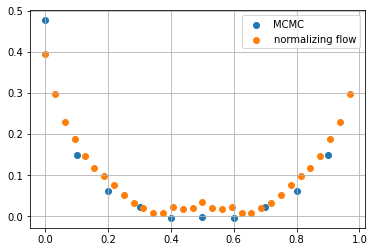

In [17]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

g=g[:-1]
print(len(g))

fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(MCMC_list,g)
plt.scatter(NF_list,g_nf)
plt.legend(["MCMC","normalizing flow"])
plt.grid(True)
plt.show()
